In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.fathomnet_model import *
import hierarchical_yolo.utils
import itertools

In [2]:
RETRAIN = True

In [3]:
import numpy as np
import cv2
from PIL import Image
from ultralytics.utils.ops import scale_boxes, xywh2xyxy

def rescale_boxes(pred_boxes, from_shape, to_shape):
    """
    Rescales predicted boxes from model input shape to original image shape.

    Args:
        pred_boxes (np.ndarray): (R, 4) array of [x1, y1, x2, y2]
        from_shape (tuple): (height, width) of model input, e.g., (640, 640)
        to_shape (tuple): (height, width) of original image

    Returns:
        np.ndarray: Rescaled boxes of shape (R, 4)
    """
    
    gain_w = to_shape[1] / from_shape[1]
    gain_h = to_shape[0] / from_shape[0]
    print(from_shape, to_shape)
    print(gain_w, gain_h)

    pred_boxes[..., [0,2]] *= gain_w
    pred_boxes[..., [1,3]] *= gain_h
    return pred_boxes
    

def draw_boxes_on_image(pil_img, boxes, labels=None, scores=None, box_color=(0, 255, 0), text_color=(255, 255, 255), scaled=(640,640)):
    """
    Draws bounding boxes with optional labels and scores onto an image.

    Args:
        pil_img (PIL.Image): Original image
        boxes (np.ndarray): (R, 4) array of boxes [x1, y1, x2, y2]
        labels (list of str): List of class names for each box
        scores (list of float): Confidence scores
        box_color (tuple): BGR color for boxes
        text_color (tuple): BGR color for text

    Returns:
        PIL.Image: Annotated image
    """
    img_cv = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    for i, box in enumerate(boxes):
        #box = xywh2xyxy(box.clone())
        box = rescale_boxes(box.clone(), scaled, pil_img.size[::-1])

        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), box_color, 2)

        label_text = ''
        if labels is not None:
            label_text += labels[i]
        if scores is not None:
            label_text += f' {scores[i]:.2f}' if label_text else f'{scores[i]:.2f}'

        if label_text:
            cv2.putText(img_cv, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

    return Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))


In [4]:
import requests

WORMS_TREE_URL = 'https://www.marinespecies.org/rest/AphiaClassificationByAphiaID/{}'
WORMS_NAME_URL = 'https://www.marinespecies.org/rest/AphiaNameByAphiaID/{}'
WORMS_ID_URL = 'https://www.marinespecies.org/rest/AphiaIDByName/{}?marine_only=true&extant_only=true'

def get_WORMS_id(name):
    result = requests.get(WORMS_ID_URL.format(name))
    return int(result.content)

def get_WORMS_name(WORMS_id):
    result = requests.get(WORMS_NAME_URL.format(WORMS_id))
    return result.content.decode("utf-8")[1:-1]

def get_WORMS_tree(organism_id):
    '''
        >>> get_WORMS_tree('Gnathostomata')
        {
          "AphiaID": 1,
          "rank": "Superdomain",
          "scientificname": "Biota",
          "child": {
            "AphiaID": 2,
            "rank": "Kingdom",
            "scientificname": "Animalia",
            "child": {
              "AphiaID": 1821,
              "rank": "Phylum",
              "scientificname": "Chordata",
              "child": {
                "AphiaID": 146419,
                "rank": "Subphylum",
                "scientificname": "Vertebrata",
                "child": {
                  "AphiaID": 1828,
                  "rank": "Infraphylum",
                  "scientificname": "Gnathostomata",
                  "child": null
                }
              }
            }
          }
        }
    '''
    result = requests.get(WORMS_TREE_URL.format(organism_id))
    blah = str(result.content)
    if 'Hexacorallia' in blah:
        print(result.json())
    return result.json()

def WORMS_tree_to_childparent_tree(worms_trees):
    childparent_tree = {}
    for tree in worms_trees:
        try:
            parent = tree['AphiaID']
        except Exception as e:
            print("could not find id")
            print(tree)
            raise e
        while 'child' in tree and tree['child']:
            tree = tree['child']
            try:
                child = tree['AphiaID']
            except Exception as e:
                print("could not find id")
                print(tree)
                raise e
            childparent_tree[child] = parent
            parent = child
    return childparent_tree

def find_closest_permitted_parent(node, tree, permitted_nodes):
    if node not in tree:
        return None
    parent = tree[node]
    while parent not in permitted_nodes:
        if parent in tree:
            parent = tree[parent]
        else:
            return None
    return parent

def trim_childparent_tree(tree, permitted_nodes):
    new_tree = {}
    for node in tree:
        closest_permitted_parent = find_closest_permitted_parent(node, tree, permitted_nodes)
        new_tree[node] = closest_permitted_parent
    for node in list(new_tree.keys()):
        if new_tree[node] is None or (node not in permitted_nodes):
            del new_tree[node]
    return new_tree
        
    

def dict_keyvalue_replace(old_dict, replacemap):
    new_dict = {}
    for key in old_dict:
        new_dict[replacemap[key]] = replacemap[old_dict[key]]
    return new_dict
    

In [5]:
example_WORMS_id = get_WORMS_id('Abyssocucumis abyssorum')
example_WORMS_id

124597

In [6]:
get_WORMS_name(example_WORMS_id)

'Abyssocucumis abyssorum'

In [7]:
tree = get_WORMS_tree(example_WORMS_id)
tree

{'AphiaID': 1,
 'rank': 'Superdomain',
 'scientificname': 'Biota',
 'child': {'AphiaID': 2,
  'rank': 'Kingdom',
  'scientificname': 'Animalia',
  'child': {'AphiaID': 1806,
   'rank': 'Phylum',
   'scientificname': 'Echinodermata',
   'child': {'AphiaID': 148744,
    'rank': 'Subphylum',
    'scientificname': 'Echinozoa',
    'child': {'AphiaID': 123083,
     'rank': 'Class',
     'scientificname': 'Holothuroidea',
     'child': {'AphiaID': 1393249,
      'rank': 'Subclass',
      'scientificname': 'Actinopoda',
      'child': {'AphiaID': 123111,
       'rank': 'Order',
       'scientificname': 'Dendrochirotida',
       'child': {'AphiaID': 123187,
        'rank': 'Family',
        'scientificname': 'Cucumariidae',
        'child': {'AphiaID': 123475,
         'rank': 'Genus',
         'scientificname': 'Abyssocucumis',
         'child': {'AphiaID': 124597,
          'rank': 'Species',
          'scientificname': 'Abyssocucumis abyssorum',
          'child': None}}}}}}}}}}

In [8]:
ids = list(map(get_WORMS_id, ['Abyssocucumis abyssorum', 'Acanthascinae', 'Cucumariidae']))
trees = map(get_WORMS_tree, ids)
worms_tree = WORMS_tree_to_childparent_tree(trees)
worms_tree

{2: 1,
 1806: 2,
 148744: 1806,
 123083: 148744,
 1393249: 123083,
 123111: 1393249,
 123187: 123111,
 123475: 123187,
 124597: 123475,
 558: 2,
 22612: 558,
 131590: 22612,
 171834: 131590,
 131694: 171834,
 723592: 131694}

In [9]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


## Data

- Get the data [here](https://www.kaggle.com/competitions/fathomnet-2025/data).  
- Make a new directory in `hierarchical_yolo/data` called `fathomenet`.  
- Put the downloaded zip file into the `hierarchical_yolo/data/fathomnet`
- `unzip` said zip file directly into that folder
- make a new directory `hierarchical_yolo/data/fathomnet/test`
- move the `dataset_test.json` file into that directory

In [10]:
DATA = '../data'
DOWNLOAD_PATH = os.path.join(DATA, 'fathomnet')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'dataset_train.json')
TRAINING_PATH = os.path.join(DOWNLOAD_PATH, 'train')
HIERARCHY_COCO_PATH = os.path.join(TRAINING_PATH, 'dataset_train.json')
YOLO_PATH = os.path.join(TRAINING_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'dataset_train', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [11]:
coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [12]:
def coco_category_dist(coco):
    import matplotlib.pyplot as plt
    cats, cnt = np.unique(list(map(lambda x: x['category_id'], coco.anns.values())), return_counts=True)
    cat_names = list(map(lambda cat_id: coco.cats[cat_id]['name'], cats))
    plt.bar(cat_names, cnt)
    for i, value in enumerate(cnt):
        plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

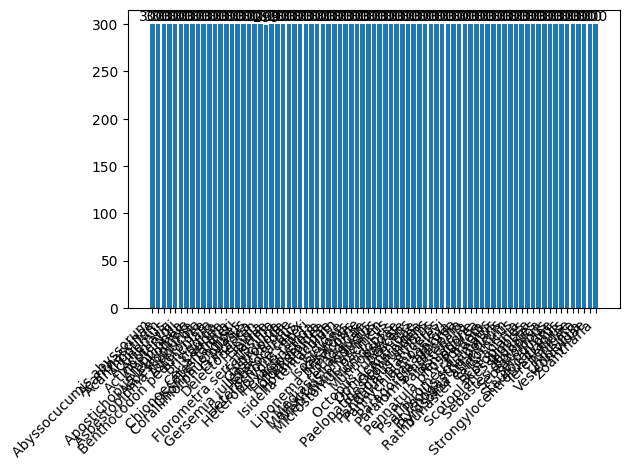

In [13]:
coco_category_dist(coco)

In [14]:
hierarchy_coco = pycocotools.coco.COCO(HIERARCHY_COCO_PATH)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [15]:
hierarchy_category_id_map = {cat['name']: cat['id'] for cat in hierarchy_coco.cats.values()}
hierarchy_category_name_map = {hierarchy_category_id_map[name]: name for name in hierarchy_category_id_map}
hierarchy_category_id_map

{'Abyssocucumis abyssorum': 1,
 'Acanthascinae': 2,
 'Acanthoptilum': 3,
 'Actinernus': 4,
 'Actiniaria': 5,
 'Actinopterygii': 6,
 'Amphipoda': 7,
 'Apostichopus leukothele': 8,
 'Asbestopluma': 9,
 'Asbestopluma monticola': 10,
 'Asteroidea': 11,
 'Benthocodon pedunculata': 12,
 'Brisingida': 13,
 'Caridea': 14,
 'Ceriantharia': 15,
 'Chionoecetes tanneri': 16,
 'Chorilia longipes': 17,
 'Corallimorphus pilatus': 18,
 'Crinoidea': 19,
 'Delectopecten': 20,
 'Elpidia': 21,
 'Farrea': 22,
 'Florometra serratissima': 23,
 'Funiculina': 24,
 'Gastropoda': 25,
 'Gersemia juliepackardae': 26,
 'Heterocarpus': 27,
 'Heterochone calyx': 28,
 'Heteropolypus ritteri': 29,
 'Hexactinellida': 30,
 'Hippasteria': 31,
 'Holothuroidea': 32,
 'Hormathiidae': 33,
 'Isidella tentaculum': 34,
 'Isididae': 35,
 'Isosicyonis': 36,
 'Keratoisis': 37,
 'Liponema brevicorne': 38,
 'Lithodidae': 39,
 'Mediaster aequalis': 40,
 'Merluccius productus': 41,
 'Metridium farcimen': 42,
 'Microstomus pacificus': 4

In [16]:
yolo_category_id_map = {name: hierarchy_category_id_map[name] - 1 for name in hierarchy_category_id_map}
yolo_category_name_map = {yolo_category_id_map[name]: name for name in yolo_category_id_map}
yolo_category_id_map

{'Abyssocucumis abyssorum': 0,
 'Acanthascinae': 1,
 'Acanthoptilum': 2,
 'Actinernus': 3,
 'Actiniaria': 4,
 'Actinopterygii': 5,
 'Amphipoda': 6,
 'Apostichopus leukothele': 7,
 'Asbestopluma': 8,
 'Asbestopluma monticola': 9,
 'Asteroidea': 10,
 'Benthocodon pedunculata': 11,
 'Brisingida': 12,
 'Caridea': 13,
 'Ceriantharia': 14,
 'Chionoecetes tanneri': 15,
 'Chorilia longipes': 16,
 'Corallimorphus pilatus': 17,
 'Crinoidea': 18,
 'Delectopecten': 19,
 'Elpidia': 20,
 'Farrea': 21,
 'Florometra serratissima': 22,
 'Funiculina': 23,
 'Gastropoda': 24,
 'Gersemia juliepackardae': 25,
 'Heterocarpus': 26,
 'Heterochone calyx': 27,
 'Heteropolypus ritteri': 28,
 'Hexactinellida': 29,
 'Hippasteria': 30,
 'Holothuroidea': 31,
 'Hormathiidae': 32,
 'Isidella tentaculum': 33,
 'Isididae': 34,
 'Isosicyonis': 35,
 'Keratoisis': 36,
 'Liponema brevicorne': 37,
 'Lithodidae': 38,
 'Mediaster aequalis': 39,
 'Merluccius productus': 40,
 'Metridium farcimen': 41,
 'Microstomus pacificus': 42

In [17]:
len(hierarchy_coco.cats)

271

In [18]:
hierarchy_coco.info()

year: 2025
version: 0
description: Generated by FathomNet
contributor: FathomNet
url: https://database.fathomnet.org
date_created: 2025/01/08


In [19]:
np.unique(list(map(lambda ann: ann['category_id'], coco.anns.values())))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79])

In [20]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [21]:
mlflow.autolog()

In [22]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [23]:
#TODO we need to get the hierarchy to train this!s

In [24]:
BATCH_FACTOR = 5 # tweak this to maximize GPU usage

In [25]:
if RETRAIN:
    results = model.train(
        data=YOLO_TRAIN_YAML, 
        epochs=60, imgsz=640, 
        device=devices, 
        batch=BATCH_FACTOR*max(len(devices), 1),
        trainer=FathomnetHierarchicalDetectionTrainer,
        val=False,
        save=True,
        save_period=3
    )

New https://pypi.org/project/ultralytics/8.3.184 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/fathomnet/train/yolo_training_data/train.yaml, epochs=60, time=None, patience=100, batch=35, imgsz=640, save=Tr

train: Scanning /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/labels.cache... 8980 images, 1 backgrounds, 5 corrupt: 100%|██████████| 8981/8981 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1965.8±829.7 MB/s, size: 3122.2 KB)
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/48806fd4-1b1c-440e-9eec-88d870a9be8a.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.00444]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/71af176f-af7e-4314-b9c4-4927785a3869.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.00469]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/76523c8e-4a04-4ff6-9590-e5060db4bb69.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.02315]
train: /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/images/95065656-53c4-4474-b7ec-a8104b0f62b2.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.04459

val: Scanning /home/noaa_brown/hierarchical_yolo/data/fathomnet/train/yolo_training_data/dataset_train/labels.cache... 8980 images, 1 backgrounds, 5 corrupt: 100%|██████████| 8981/8981 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train120/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=3.6e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000546875), 63 bias(decay=0.0)
MLflow: logging run_id(ef1fb874d2d04fb3bf269d698e398a06) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train120
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/257 [00:00<?, ?it/s][rank5]: Traceback (most recent call last):
[rank5]:   File "/home/noaa_brown/.config/Ultralytics/DDP/_temp_h4j883oq133140835542144.py", line 13, in <module>
[rank5]:     results = trainer.train()
[rank5]:               ^^^^^^^^^^^^^^^
[rank5]:   File "/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/ultralytics/engine/trainer.py", line 210, in train
[rank5]:     self._do_train(world_size)
[rank5]:   File "/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/ultralytics/engine/trainer.py", line 384, in _do_train
[rank5]:     loss, self.loss_items = self.model(batch)
[rank5]:                             ^^^^^^^^^^^^^^^^^
[rank5]:   File "/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
[rank5]:     return self._call_impl(*args, **kwargs)
[rank5]:            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[rank5]:   File "/home/noaa_brown/hierar

CalledProcessError: Command '['/home/noaa_brown/hierarchical_yolo/.venv/bin/python3', '-m', 'torch.distributed.run', '--nproc_per_node', '7', '--master_port', '39273', '/home/noaa_brown/.config/Ultralytics/DDP/_temp_h4j883oq133140835542144.py']' returned non-zero exit status 1.

In [300]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/fathomnet/train/yolo_training_data/dataset_train/images/3750b38c-be9b-49e6-99a5-948ebcab1f5a.png'

In [301]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [302]:
MODEL_WEIGHTS_PATH = os.path.join(MODEL_LOCATION, latest_model, 'weights')

In [303]:
desired_epoch = None
if desired_epoch:
    weights_file = f'epoch{desired_epoch}.pt'
else:
    weights_file = 'best.pt'
checkpoint_path = os.path.join(MODEL_WEIGHTS_PATH, weights_file)
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt')).to('cuda')
trained_model.eval()

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [304]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)
prediction = next(predictions)
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 138., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 193., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124.,
        124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 138., 124., 193., 124., 124., 124., 138., 138., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124.,
        124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 124., 217., 124., 124., 124., 138., 124., 124., 124., 124., 124., 124., 124., 124., 1

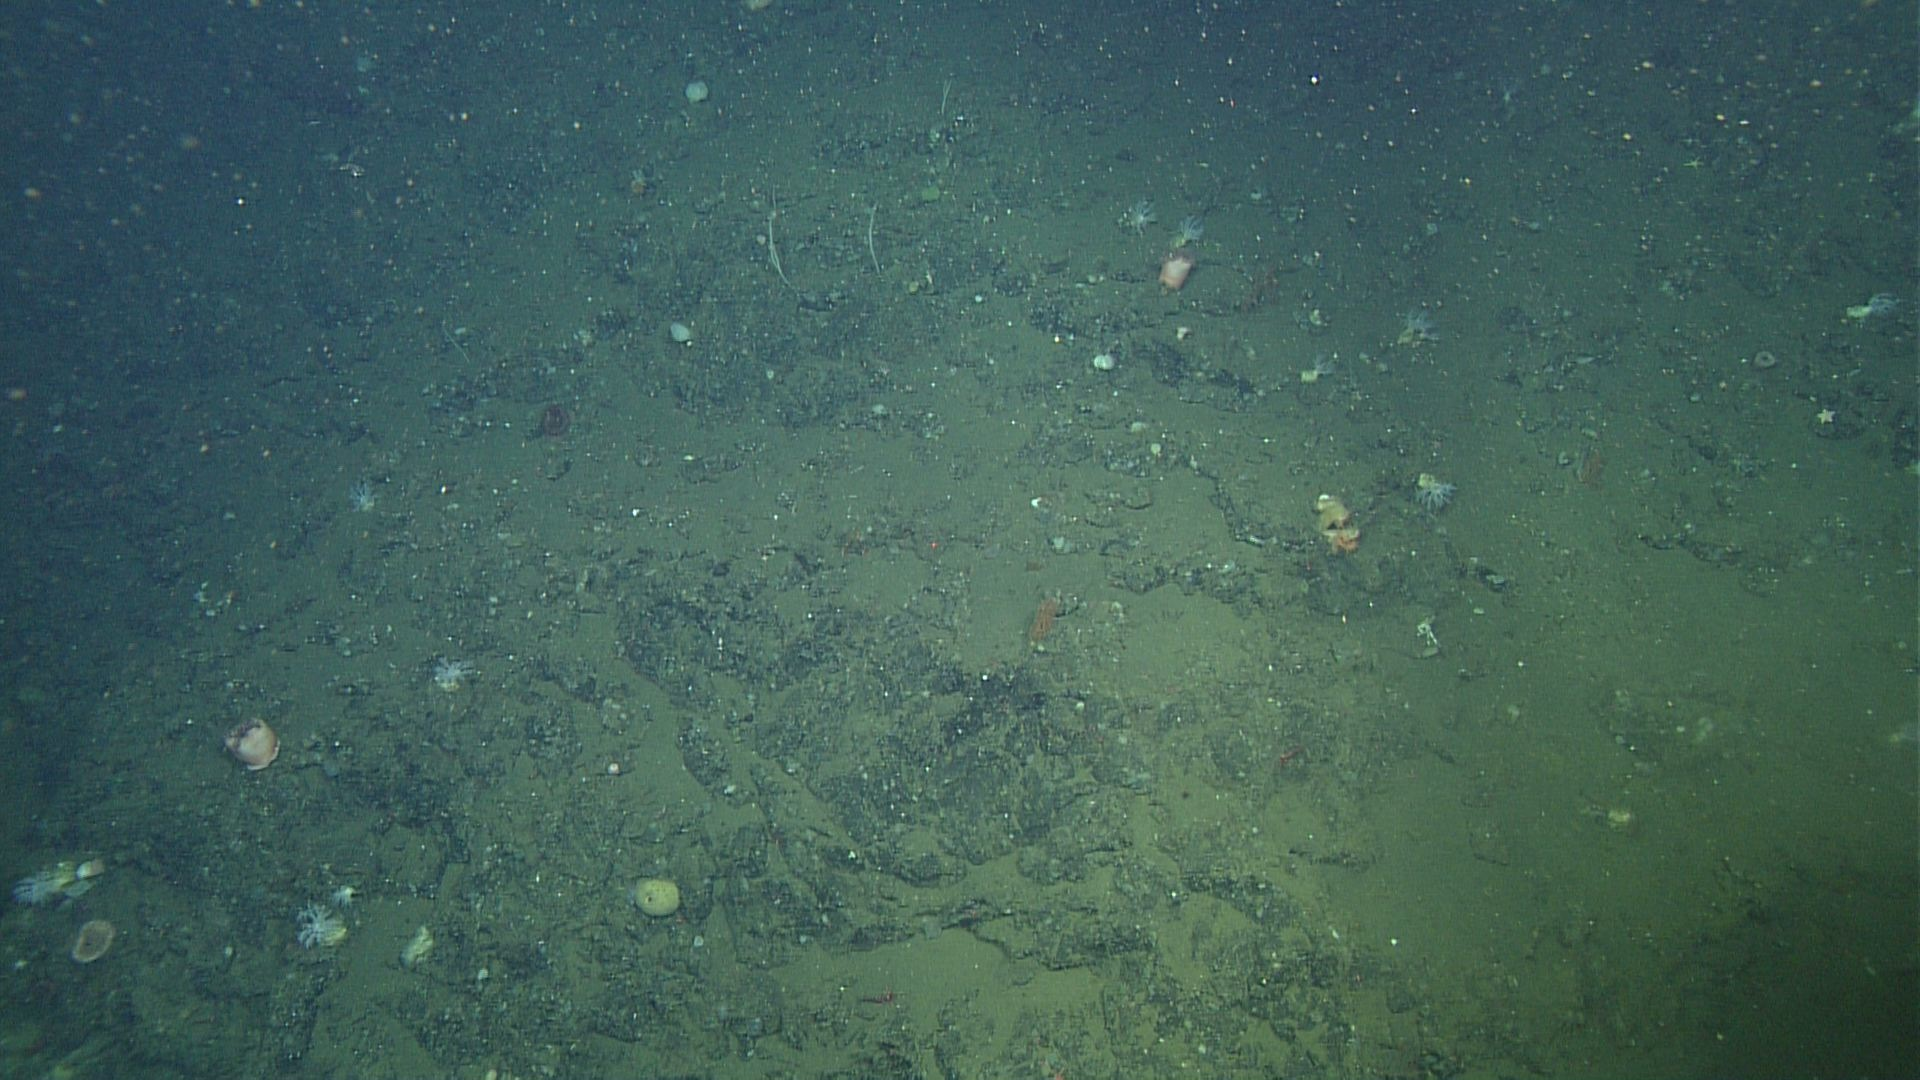

In [305]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(random_img).convert('RGB')
image

In [306]:
import importlib
importlib.reload(hierarchical_yolo.utils)

<module 'hierarchical_yolo.utils' from '/home/noaa_brown/hierarchical_yolo/hierarchical_yolo/utils.py'>

In [307]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.utils.hierarchical_predict(trained_model, FathomnetHierarchicalDetectionTrainer._hierarchy, [image, image], cuda=True)

In [308]:
predicted_paths[0][0]

[124, 138, 181, 193, 118, 133, 217, 53, 54]

In [309]:
list(map(lambda i: yolo_category_name_map[i], predicted_paths[0][0]))

['Biota',
 'Animalia',
 'Cnidaria',
 'Anthozoa',
 'Octocorallia',
 'Scleralcyonacea',
 'Coralliidae',
 'Paragorgia',
 'Paragorgia arborea']

In [310]:
FathomnetHierarchicalDetectionTrainer._hierarchy[39]

84

In [311]:
predicted_path_scores[0][0]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9528, 0.0469], device='cuda:0')

In [312]:
def truncate_path(path, score, threshold = 0.3):
    truncated_path, truncated_score = [], []
    for category, p in zip(path, score):
        if p < threshold:
            break
        truncated_path.append(category)
    return truncated_path, score[:len(truncated_path)]

In [313]:
trunc_path, trunc_score = truncate_path(predicted_paths[0][0], predicted_path_scores[0][0])
print(list(map(lambda i: yolo_category_name_map[i], trunc_path)))
trunc_score

['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9528], device='cuda:0')

In [314]:
for paths, scores in zip(predicted_paths[0], predicted_path_scores[0]):
    tpath, tscore = truncate_path(paths, scores)
    print(list(map(lambda i: yolo_category_name_map[i], tpath)))
    print(tscore)

['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9528], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9999, 0.9190], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9997, 0.9999, 0.9032], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9997, 0.9999, 0.9009], device='cuda:0')
['Biota', 'Animalia', 'Cnidaria', 'Anthozoa', 'Octocorallia', 'Scleralcyonacea', 'Coralliidae', 'Paragorgia']
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9996, 0.9999, 0.8936], device='cuda:0')


In [315]:
import functools

In [316]:
tpaths, tscores = [], []
for paths, scores in zip(predicted_paths[0], predicted_path_scores[0]):
    tpath, tscore = truncate_path(paths, scores, threshold=0.3)
    tpaths.append(tpath), tscores.append(tscore)

In [317]:
tpaths

[[124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 217, 53],
 [124, 138, 181, 193, 118, 133, 21

In [318]:
bpath, bscore = [p[-1] if p else 124 for p in tpaths], [functools.reduce(lambda x,y: x*y, s, 1) for s in tscores]

(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 1920)
3.0 1.6875
(640, 640) (1080, 19

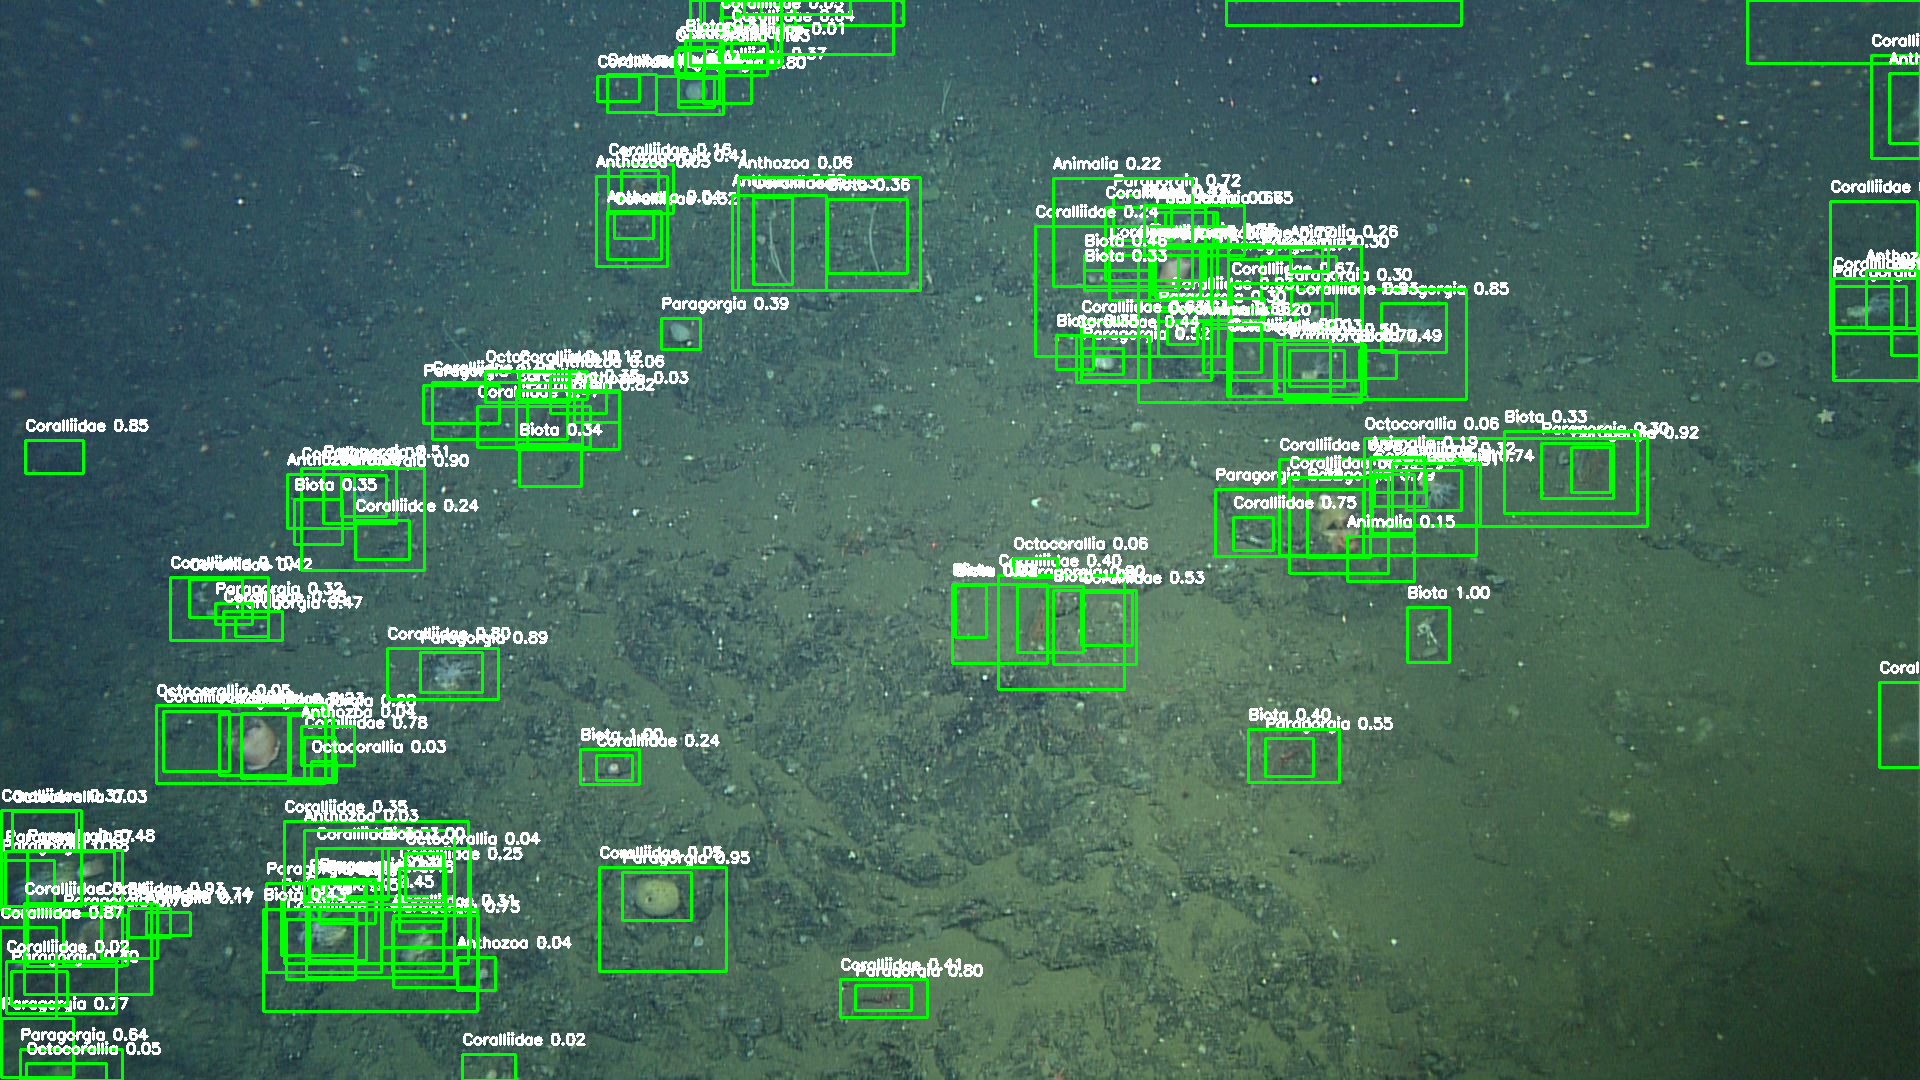

In [319]:
draw_boxes_on_image(image, predicted_boxes[0].T, 
                    labels=[yolo_category_name_map[p] for p in bpath], 
                    scores=bscore, box_color=(0, 255, 0), text_color=(255, 255, 255))

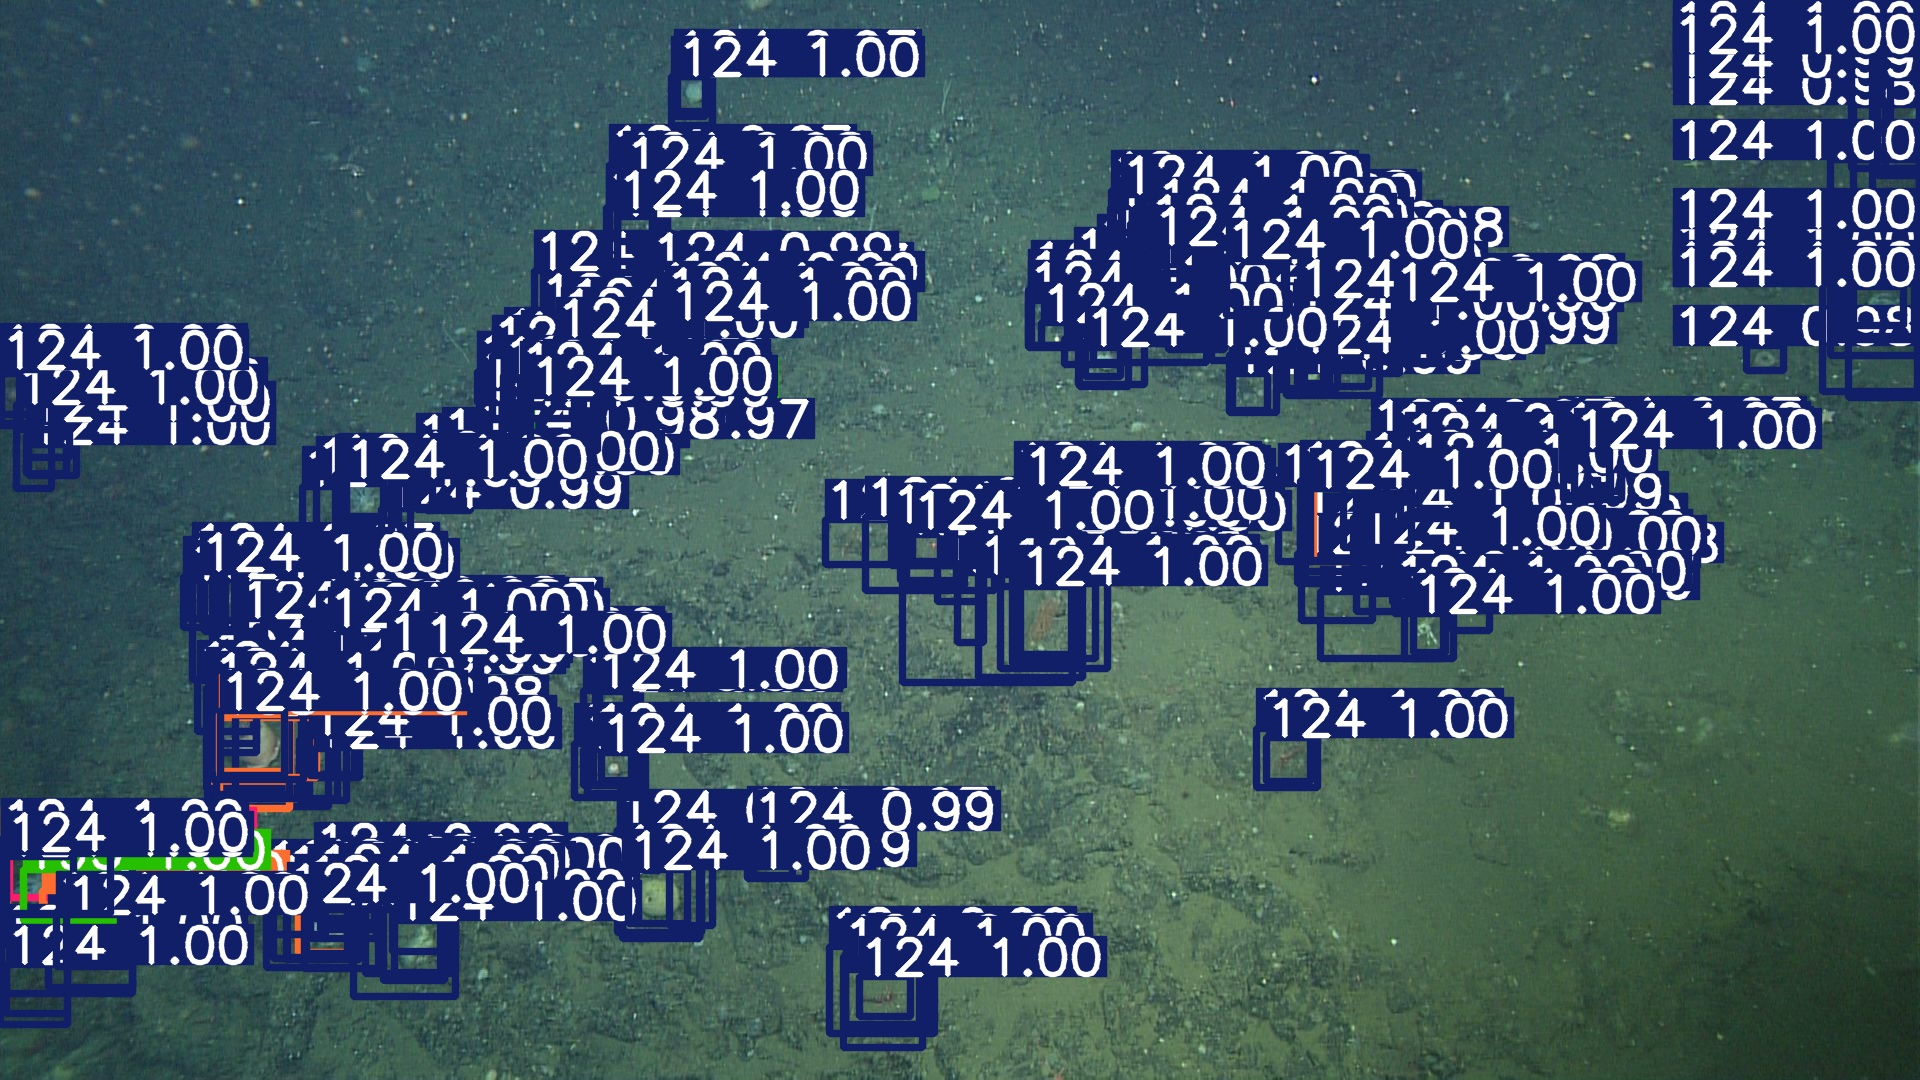

In [320]:
prediction.save('pickles.jpg')
from IPython.display import Image as IPy_Image
IPy_Image(filename='pickles.jpg') 

In [ ]:
TEST_PATH = os.path.join(DOWNLOAD_PATH, 'test')
TEST_COCO_PATH = os.path.join(TEST_PATH, 'dataset_test.json')
TEST_IMAGES_PATH = os.path.join(TEST_PATH, 'images')
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)

In [ ]:
test_coco = pycocotools.coco.COCO(TEST_COCO_PATH)

In [ ]:
test_coco.download(TEST_IMAGES_PATH)

In [ ]:
test_images = list(map(lambda im: os.path.join(TEST_IMAGES_PATH, im), os.listdir(TEST_IMAGES_PATH)))

In [ ]:
loaded_images = list(map(lambda im: Image.open(im).convert('RGB'), test_images))

In [ ]:
predicted_boxes, predicted_paths, predicted_path_scores = [], [], []

i=0
for batch in itertools.batched(loaded_images, n=25):
    i+=1
    print(i)
    pb, pp, pps = hierarchical_yolo.utils.hierarchical_predict(trained_model, FathomnetHierarchicalDetectionTrainer._hierarchy, batch, cuda=True)
    predicted_boxes += pb
    predicted_paths += pp
    predicted_path_scores += pps

In [ ]:
predicted_boxes[0][:,0]

In [ ]:
predicted_boxes[0][:,2]

In [ ]:
predicted_boxes[0].min()

In [ ]:
i = int(np.random.uniform(1, len(loaded_images)))
i

In [ ]:
import functools

In [ ]:
tpaths, tscores = [], []
for paths, scores in zip(predicted_paths[i], predicted_path_scores[i]):
    tpath, tscore = truncate_path(paths, scores)
    tpaths.append(tpath), tscores.append(tscore)

In [ ]:
bpath, bscore = [p[-1] for p in tpaths], [functools.reduce(lambda x,y: x*y, s, 1) for s in tscores]

In [ ]:
loaded_images[i].size

In [ ]:
rescale_boxes(predicted_boxes[i].T.clone(), (640,640), loaded_images[i].size[::-1])

In [ ]:
predicted_boxes[i].T

In [ ]:
draw_boxes_on_image(loaded_images[i], predicted_boxes[i].T, 
                    labels=[yolo_category_name_map[p] for p in bpath], 
                    scores=bscore, box_color=(0, 255, 0), text_color=(255, 255, 255))